# Importando bibliotecas e preparando o ambiente

Importando as bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GRU, LSTM, Bidirectional

Montando o seu drive no colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dados_train = pd.read_json('/content/drive/MyDrive/Colab Notebooks/LITE/data/processed_data/train_processed.json', lines=True)

dados_teste = pd.read_json('/content/drive/MyDrive/Colab Notebooks/LITE/data/processed_data/test_processed.json', lines=True)

In [ ]:
df_types = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LITE/data/processed_data/types.txt', on_bad_lines='skip')

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

In [ ]:
np.random.seed(94)
tf.random.set_seed(94)

Mostrar as primeiras linhas do DataFrame

In [ ]:
dados_train.head(4)

,premise,entity,annotation,id
0,The British Information Commissioner 's Office...,Web users,"[citizen, person, user]",train0000
1,Tushar Gandhi said the Australian - born tycoo...,he,"[criminal, entrepreneur, businessperson, busin...",train0001
2,They hope to find out before the annual monsoo...,They,"[expert, scholar, scientist, person]",train0002
3,"A set of bills in the House and Senate would ,...",USPS,"[administration, system, business, organization]",train0003


## Pré-processando os dados

In [ ]:
# Criando um DataFrame para as linhas que terão positiva
df_train = pd.DataFrame(columns=['context', 'class'])
df_test = pd.DataFrame(columns=['context', 'class'])

In [ ]:
# Criando uma nova linha para cada anotação com os mesmos dados
df_train_exploded = dados_train.explode('annotation').reset_index(drop=True)
df_test_exploded = dados_teste.explode('annotation').reset_index(drop=True)

In [ ]:
# Função para processar cada linha do DataFrame
def process_row(row):
    premise = row['premise'].rstrip(' .')
    entity = row['entity']
    annotation = row['annotation']
    return f"{premise}. {entity} is {annotation}."

In [ ]:
# Aplicando a função a cada linha do DataFrame
df_train['context'] = df_train_exploded.apply(process_row, axis=1)
df_test['context'] = df_test_exploded.apply(process_row, axis=1)

In [ ]:
# Indicando que o contexto é verdadeiro
df_train['class'] = 1
df_test['class'] = 1

In [ ]:
df_train.head(3)

,context,class
0,The British Information Commissioner 's Office...,1
1,The British Information Commissioner 's Office...,1
2,The British Information Commissioner 's Office...,1


In [ ]:
# Retorna uma lista de tipos escolhidos aleatóriamente para a quantidade passada
def generate_random_words():
    number_to_select = random.randint(1, 10)
    random_words = df_types.sample(n=number_to_select)['person'].tolist()

    return random_words

In [ ]:
def generateNegLine(df_premise):
  new_rows = []

  for index, row in df_premise.iterrows():
     random_words = generate_random_words()
     new_rows.append(random_words)

  return new_rows

In [ ]:
dados_train_negative = dados_train.copy()
dados_test_negative = dados_teste.copy()

In [ ]:
dados_train_negative["annotation"] = generateNegLine(dados_train_negative)
dados_test_negative["annotation"] = generateNegLine(dados_test_negative)

In [ ]:
dados_train_negative_exploded = dados_train_negative.explode('annotation').reset_index(drop=True)
dados_test_negative_exploded = dados_test_negative.explode('annotation').reset_index(drop=True)

In [ ]:
df_train_negative = pd.DataFrame(columns=['context', 'class'])
df_test_negative = pd.DataFrame(columns=['context', 'class'])

In [ ]:
# Aplicando a função a cada linha do DataFrame
df_train_negative['context'] = dados_train_negative_exploded.apply(process_row, axis=1)
df_test_negative['context'] = dados_test_negative_exploded.apply(process_row, axis=1)

In [ ]:
# Indicando que o contexto é falso
df_train_negative['class'] = 0
df_test_negative['class'] = 0

In [ ]:
# Concatenando os casos positivos e negativos
train = pd.concat([df_train, df_train_negative], ignore_index=True)
test = pd.concat([df_test, df_test_negative], ignore_index=True)

In [ ]:
# Embaralhando as linhas
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print('Tamanho de dados treinamento positivos: ', df_train.shape)
print('Tamanho de dados treinamento negativos: ', df_train_negative.shape)
print('Tamanho de dados treinamento total: ', train.shape)
print('Tamanho de dados teste positivos: ', df_test.shape)
print('Tamanho de dados teste negativos: ', df_test_negative.shape)
print('Tamanho de dados teste total: ', test.shape)

Tamanho de dados treinamento positivos:  (10778, 2)
Tamanho de dados treinamento negativos:  (10873, 2)
Tamanho de dados treinamento total:  (21651, 2)
Tamanho de dados teste positivos:  (10733, 2)
Tamanho de dados teste negativos:  (10867, 2)
Tamanho de dados teste total:  (21600, 2)


# Preparando para treinar

Selecionando colunas específicas

In [ ]:
X = train.iloc[:, 0] # Coluna dos dados pré-processados
y = train.iloc[:, 1] # Coluna dos rótulos

X_test = test.iloc[:, 0]  # Coluna dos dados pré-processados
y_test = test.iloc[:, 1]  # Coluna dos rótulos

Mostrar as primeiras linhas de cada coluna

In [ ]:
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())


Rótulos:
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64

Dados preprocessados:
0    It 's not unusual for severely damaged trees l...
1    `` We must have a restructuring proposal from ...
2    Authorities have taken a series of measures re...
3    Fanfiction.Net received a cease and desist ord...
4    He said he expects the current $ 1 billion fun...
Name: context, dtype: object


# Uma implementação ingênua para o problema

Abaixo uma implementação ingênua para o problema. Ela é ingênua por que desconsidera a ordem das palavras no texto.
Tente endendê-la e execute o treinamento.

### Pré-processamento

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

Codificação dos rótulos para 0 e 1

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

Tokenização e sequenciamento dos textos

In [ ]:
max_length = 280  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

Divisão dos dados em conjuntos de treino e validação

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

### Definição e treinamento do modelo

Definição do modelo

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [ ]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 32)                143392    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1743425 (6.65 MB)
Trainable params: 1743425 (6.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [ ]:
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 6s - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6894 - val_accuracy: 0.5384 - 6s/epoch - 10ms/step
Epoch 2/5
542/542 - 5s - loss: 0.6358 - accuracy: 0.6452 - val_loss: 0.5978 - val_accuracy: 0.6811 - 5s/epoch - 10ms/step
Epoch 3/5
542/542 - 5s - loss: 0.4897 - accuracy: 0.7765 - val_loss: 0.5483 - val_accuracy: 0.7271 - 5s/epoch - 9ms/step
Epoch 4/5
542/542 - 5s - loss: 0.3918 - accuracy: 0.8286 - val_loss: 0.5117 - val_accuracy: 0.7703 - 5s/epoch - 10ms/step
Epoch 5/5
542/542 - 5s - loss: 0.3268 - accuracy: 0.8588 - val_loss: 0.5294 - val_accuracy: 0.7751 - 5s/epoch - 9ms/step


Plotando as curvas de loss

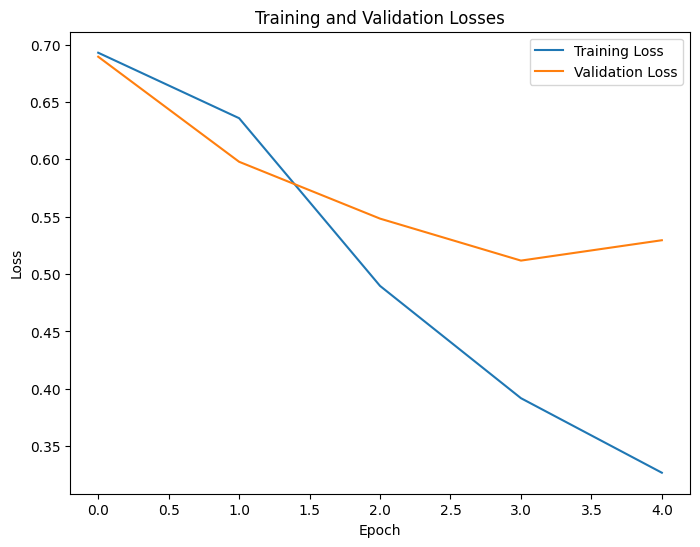

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 1s - loss: 0.7013 - accuracy: 0.7395 - 1s/epoch - 2ms/step
Perda nos dados de teste: 0.7013
Acurácia nos dados de teste: 0.7395


Gerando o relatório de classificação

In [ ]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 1s 1ms/step


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.693551961001551
	Recall: 0.8640839238060182
	F1-score: 0.7694829140375317
Class: 1
	Precision: 0.8167721126411115
	Recall: 0.6134351998509271
	F1-score: 0.7006491433436202
Class: macro avg
	Precision: 0.7551620368213312
	Recall: 0.7387595618284726
	F1-score: 0.7350660286905759
Class: weighted avg
	Precision: 0.7547798261657827
	Recall: 0.739537037037037
	F1-score: 0.7352795408496727
Macro Avg: {'precision': 0.7551620368213312, 'recall': 0.7387595618284726, 'f1-score': 0.7350660286905759, 'support': 21600}
Weighted Avg: {'precision': 0.7547798261657827, 'recall': 0.739537037037037, 'f1-score': 0.7352795408496727, 'support': 21600}


Plotando a matriz de confusão

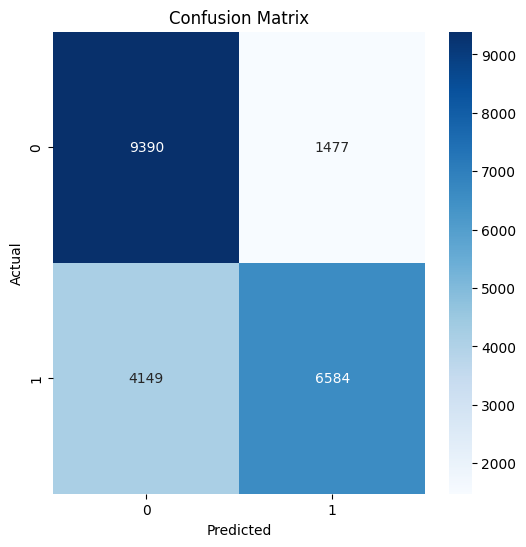

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Faça o mesmo processamento utilizando GRU

Pelo menos duas camadas de GRU

In [ ]:
embedding_dim = 16

model_GRU = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(64, return_sequences=True, trainable=True),
    GRU(64, trainable=True),
    Dense(32, activation='relu', trainable=True),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 gru (GRU)                   (None, 280, 64)           15744     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1642817 (6.27 MB)
Trainable params: 1642817 (6.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [ ]:
epochs = 5
history = model_GRU.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 89s - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5075 - 89s/epoch - 163ms/step
Epoch 2/5
542/542 - 91s - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.5075 - 91s/epoch - 168ms/step
Epoch 3/5
542/542 - 85s - loss: 0.6933 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.4925 - 85s/epoch - 157ms/step
Epoch 4/5
542/542 - 83s - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6933 - val_accuracy: 0.4925 - 83s/epoch - 154ms/step
Epoch 5/5
542/542 - 83s - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4925 - 83s/epoch - 153ms/step


Plotando as curvas de loss

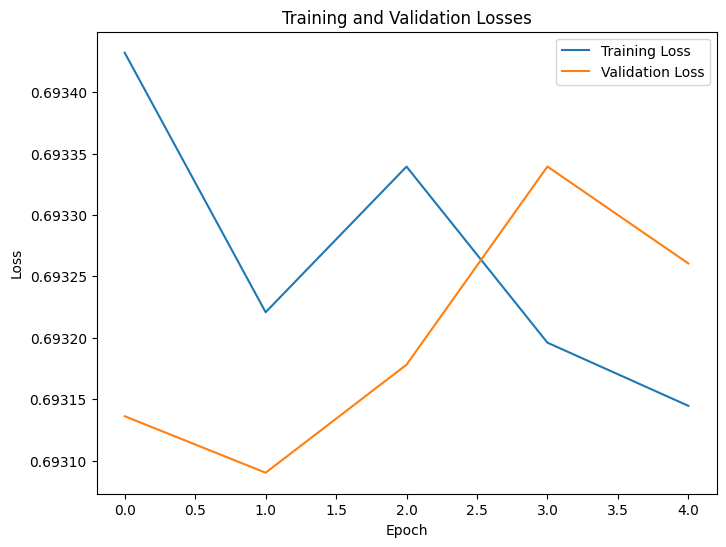

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model_GRU.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 22s - loss: 0.6931 - accuracy: 0.5031 - 22s/epoch - 32ms/step
Perda nos dados de teste: 0.6931
Acurácia nos dados de teste: 0.5031


Gerando o relatório de classificação

In [ ]:
y_pred = (model_GRU.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 23s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.5031018518518519
	Recall: 1.0
	F1-score: 0.6694181784581268
Class: 1
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: macro avg
	Precision: 0.25155092592592593
	Recall: 0.5
	F1-score: 0.3347090892290634
Class: weighted avg
	Precision: 0.2531114733367627
	Recall: 0.5031018518518519
	F1-score: 0.33678552524557703
Macro Avg: {'precision': 0.25155092592592593, 'recall': 0.5, 'f1-score': 0.3347090892290634, 'support': 21600}
Weighted Avg: {'precision': 0.2531114733367627, 'recall': 0.5031018518518519, 'f1-score': 0.33678552524557703, 'support': 21600}


Plotando a matriz de confusão

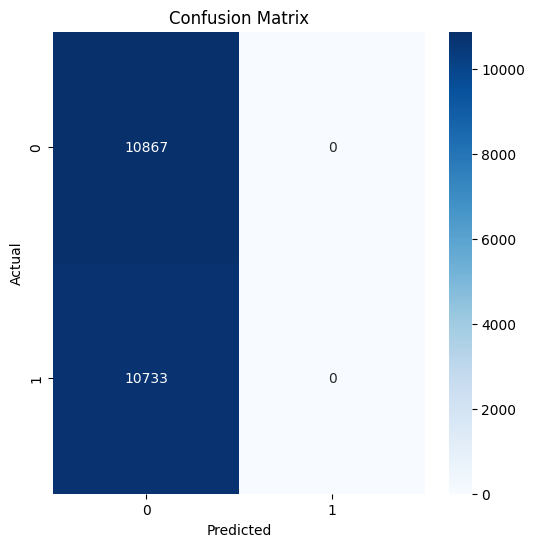

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Faça o mesmo processamento utilizando LSTM

Pelo menos duas camadas de LSTM

In [ ]:
embedding_dim = 16

model_LSTM = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True, trainable=True),
    LSTM(64, trainable=True),
    Dense(32, activation='relu', trainable=True),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 lstm (LSTM)                 (None, 280, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1655873 (6.32 MB)
Trainable params: 1655873 (6.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [ ]:
epochs = 5
history = model_LSTM.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 107s - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4925 - 107s/epoch - 198ms/step
Epoch 2/5
542/542 - 104s - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6931 - val_accuracy: 0.5075 - 104s/epoch - 192ms/step
Epoch 3/5
542/542 - 103s - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6935 - val_accuracy: 0.4925 - 103s/epoch - 191ms/step
Epoch 4/5
542/542 - 103s - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4925 - 103s/epoch - 190ms/step
Epoch 5/5
542/542 - 105s - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4925 - 105s/epoch - 193ms/step


Plotando as curvas de loss

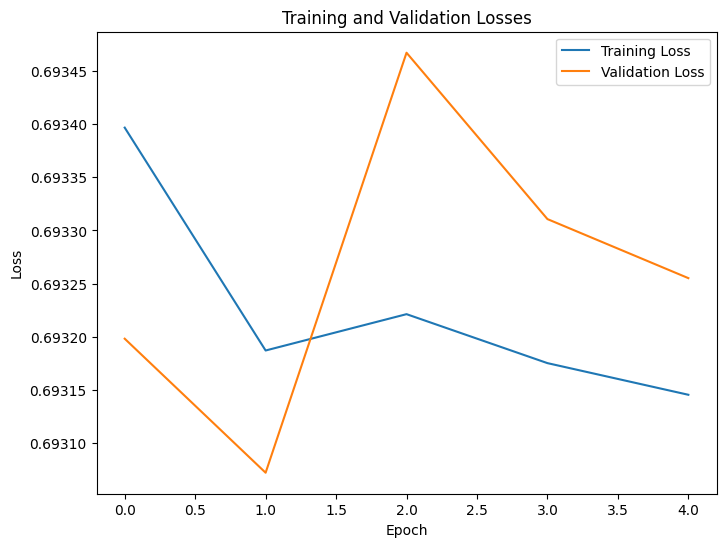

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model_LSTM.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 28s - loss: 0.6931 - accuracy: 0.5031 - 28s/epoch - 41ms/step
Perda nos dados de teste: 0.6931
Acurácia nos dados de teste: 0.5031


Gerando o relatório de classificação

In [ ]:
y_pred = (model_LSTM.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 29s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.5031018518518519
	Recall: 1.0
	F1-score: 0.6694181784581268
Class: 1
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: macro avg
	Precision: 0.25155092592592593
	Recall: 0.5
	F1-score: 0.3347090892290634
Class: weighted avg
	Precision: 0.2531114733367627
	Recall: 0.5031018518518519
	F1-score: 0.33678552524557703
Macro Avg: {'precision': 0.25155092592592593, 'recall': 0.5, 'f1-score': 0.3347090892290634, 'support': 21600}
Weighted Avg: {'precision': 0.2531114733367627, 'recall': 0.5031018518518519, 'f1-score': 0.33678552524557703, 'support': 21600}


Plotando a matriz de confusão

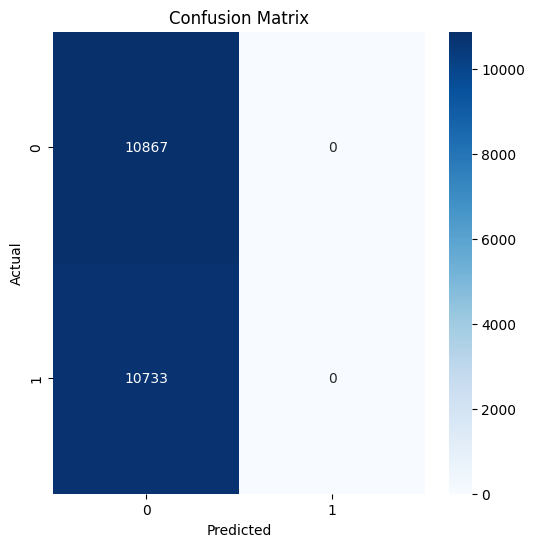

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Previsões do modelo

# Faça o mesmo processamento utilizando GRU Bi-direcionais

Pelo menos duas camadas de GRU bi-direcionais

In [ ]:
embedding_dim = 8

model_GRU2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True, trainable = True)),
    Bidirectional(GRU(64, trainable = True)),
    Dense(32, activation='relu', trainable = True),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model_GRU2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model_GRU2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 8)            800000    
                                                                 
 bidirectional (Bidirection  (None, 280, 128)          28416     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 907073 (3.46 MB)
Trainable params: 90707

Treinamento do modelo

In [ ]:
epochs = 5
history = model_GRU2.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 173s - loss: 0.6929 - accuracy: 0.5081 - val_loss: 0.6928 - val_accuracy: 0.5274 - 173s/epoch - 318ms/step
Epoch 2/5
542/542 - 161s - loss: 0.6735 - accuracy: 0.5833 - val_loss: 0.6880 - val_accuracy: 0.5468 - 161s/epoch - 298ms/step
Epoch 3/5
542/542 - 163s - loss: 0.6508 - accuracy: 0.6206 - val_loss: 0.7070 - val_accuracy: 0.5454 - 163s/epoch - 301ms/step
Epoch 4/5
542/542 - 163s - loss: 0.6395 - accuracy: 0.6323 - val_loss: 0.7017 - val_accuracy: 0.5391 - 163s/epoch - 301ms/step
Epoch 5/5
542/542 - 160s - loss: 0.6311 - accuracy: 0.6383 - val_loss: 0.6824 - val_accuracy: 0.5675 - 160s/epoch - 295ms/step


Plotando as curvas de loss

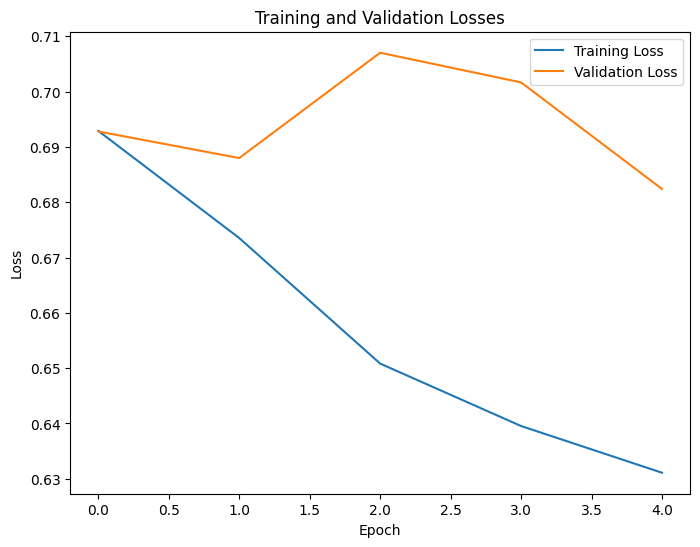

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model_GRU2.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 43s - loss: 0.6838 - accuracy: 0.5331 - 43s/epoch - 64ms/step
Perda nos dados de teste: 0.6838
Acurácia nos dados de teste: 0.5331


Gerando o relatório de classificação

In [ ]:
y_pred = (model_GRU2.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 46s 67ms/step


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.5257263324329666
	Recall: 0.7343333026594276
	F1-score: 0.6127620363971436
Class: 1
	Precision: 0.5503815605045943
	Recall: 0.3292648840026088
	F1-score: 0.4120321790835957
Class: macro avg
	Precision: 0.5380539464687805
	Recall: 0.5317990933310182
	F1-score: 0.5123971077403696
Class: weighted avg
	Precision: 0.5379774696039287
	Recall: 0.5330555555555555
	F1-score: 0.5130197420199996
Macro Avg: {'precision': 0.5380539464687805, 'recall': 0.5317990933310182, 'f1-score': 0.5123971077403696, 'support': 21600}
Weighted Avg: {'precision': 0.5379774696039287, 'recall': 0.5330555555555555, 'f1-score': 0.5130197420199996, 'support': 21600}


Plotando a matriz de confusão

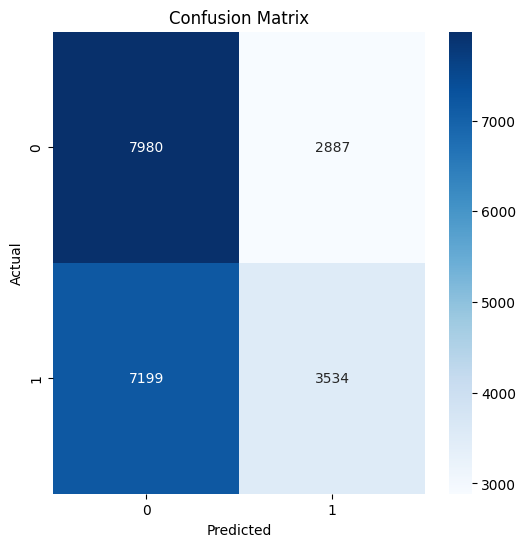

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Previsões do modelo

# Faça o mesmo processamento utilizando LSTM Bi-direcionais

Pelo menos duas camadas de LSTM Bi-direcionais

In [ ]:
embedding_dim = 16

model_LSTM2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True, trainable = True)),
    Bidirectional(LSTM(64, trainable = True)),
    Dense(32, activation='relu', trainable = True),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model_LSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model_LSTM2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 280, 128)          41472     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1744449 (6.65 MB)
Trainable params: 1744

Treinamento do modelo

In [ ]:
epochs = 5
history = model_LSTM2.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 193s - loss: 0.6933 - accuracy: 0.5092 - val_loss: 0.6915 - val_accuracy: 0.5197 - 193s/epoch - 356ms/step
Epoch 2/5
542/542 - 183s - loss: 0.6037 - accuracy: 0.6660 - val_loss: 0.5413 - val_accuracy: 0.7340 - 183s/epoch - 338ms/step
Epoch 3/5
542/542 - 183s - loss: 0.3819 - accuracy: 0.8384 - val_loss: 0.4399 - val_accuracy: 0.8289 - 183s/epoch - 339ms/step
Epoch 4/5
542/542 - 183s - loss: 0.2830 - accuracy: 0.8928 - val_loss: 0.3950 - val_accuracy: 0.8347 - 183s/epoch - 338ms/step
Epoch 5/5
542/542 - 183s - loss: 0.2211 - accuracy: 0.9164 - val_loss: 0.4097 - val_accuracy: 0.8386 - 183s/epoch - 337ms/step


Plotando as curvas de loss

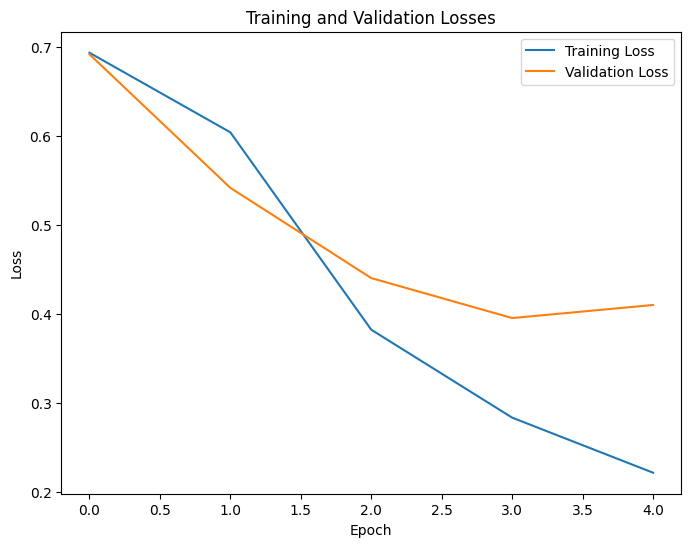

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model_LSTM2.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 51s - loss: 0.4320 - accuracy: 0.8364 - 51s/epoch - 75ms/step
Perda nos dados de teste: 0.4320
Acurácia nos dados de teste: 0.8364


Gerando o relatório de classificação

In [ ]:
y_pred = (model_LSTM2.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 55s 79ms/step


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.8190915419422207
	Recall: 0.8662004232998988
	F1-score: 0.8419875665280201
Class: 1
	Precision: 0.8561535417491096
	Recall: 0.8062983322463431
	F1-score: 0.8304783839547046
Class: macro avg
	Precision: 0.8376225418456651
	Recall: 0.8362493777731209
	F1-score: 0.8362329752413624
Class: weighted avg
	Precision: 0.8375075810129309
	Recall: 0.8364351851851852
	F1-score: 0.8362686750206406
Macro Avg: {'precision': 0.8376225418456651, 'recall': 0.8362493777731209, 'f1-score': 0.8362329752413624, 'support': 21600}
Weighted Avg: {'precision': 0.8375075810129309, 'recall': 0.8364351851851852, 'f1-score': 0.8362686750206406, 'support': 21600}


Plotando a matriz de confusão

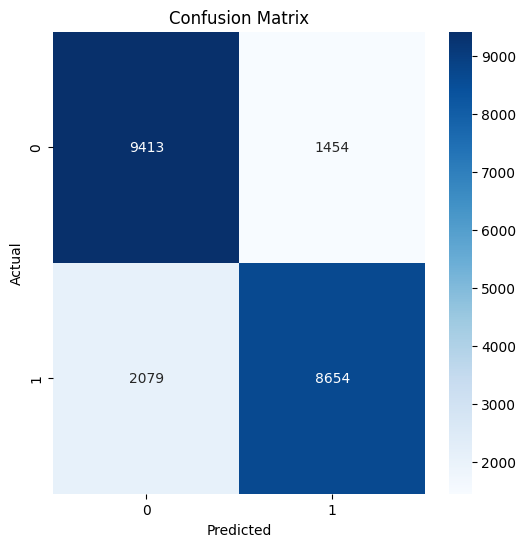

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Previsões do modelo

# Faça o mesmo processamento utilizando redes recorrentes bi-direcionais e profundas

Pelo menos quatro camadas de GRU/LSTM bi-direcionais (ou não)

In [ ]:
embedding_dim = 16

model_deep = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True, trainable = True)),
    Bidirectional(LSTM(64, return_sequences=True, trainable = True)),
    Bidirectional(LSTM(64, return_sequences=True, trainable = True)),
    Bidirectional(LSTM(64, trainable = True)),
    Dense(32, activation='relu', trainable = True),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [ ]:
model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [ ]:
model_deep.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 280, 128)          31488     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 280, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 280, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               98816     
 onal)                                                

Treinamento do modelo

In [ ]:
epochs = 5
history = model_deep.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
542/542 - 415s - loss: 0.6934 - accuracy: 0.5077 - val_loss: 0.6929 - val_accuracy: 0.5098 - 415s/epoch - 766ms/step
Epoch 2/5
542/542 - 399s - loss: 0.5916 - accuracy: 0.6715 - val_loss: 0.4836 - val_accuracy: 0.7691 - 399s/epoch - 737ms/step
Epoch 3/5
542/542 - 401s - loss: 0.3358 - accuracy: 0.8603 - val_loss: 0.3471 - val_accuracy: 0.8460 - 401s/epoch - 739ms/step
Epoch 4/5
542/542 - 401s - loss: 0.2274 - accuracy: 0.9117 - val_loss: 0.3385 - val_accuracy: 0.8559 - 401s/epoch - 740ms/step
Epoch 5/5
542/542 - 403s - loss: 0.1810 - accuracy: 0.9314 - val_loss: 0.3676 - val_accuracy: 0.8628 - 403s/epoch - 743ms/step


Plotando as curvas de loss

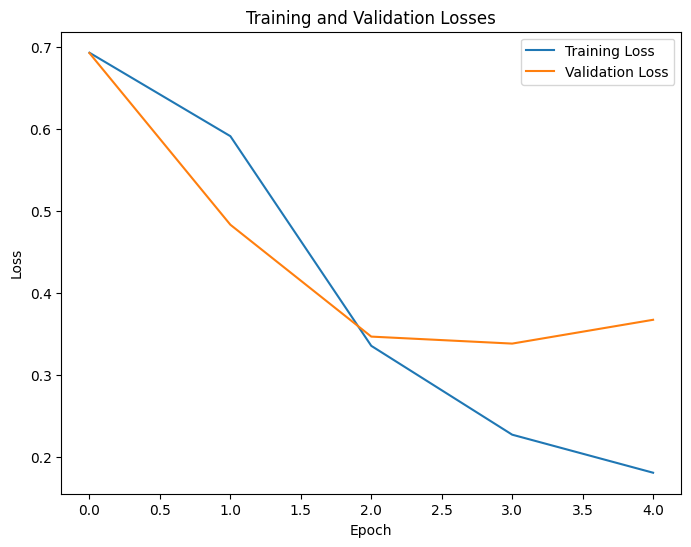

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [ ]:
loss, accuracy = model_deep.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

675/675 - 118s - loss: 0.3822 - accuracy: 0.8661 - 118s/epoch - 174ms/step
Perda nos dados de teste: 0.3822
Acurácia nos dados de teste: 0.8661


Gerando o relatório de classificação

In [ ]:
y_pred = (model_deep.predict(padded_sequences_test) > 0.5).astype("int32")

report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

675/675 [==============================] - 118s 172ms/step


Plotando os resultados

In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.8456271127676173
	Recall: 0.8977638722738567
	F1-score: 0.8709159078735941
Class: 1
	Precision: 0.889595548047302
	Recall: 0.8340631696636541
	F1-score: 0.860934795152914
Class: macro avg
	Precision: 0.8676113304074596
	Recall: 0.8659135209687554
	F1-score: 0.8659253515132541
Class: weighted avg
	Precision: 0.8674749468350644
	Recall: 0.8661111111111112
	F1-score: 0.8659563114462302
Macro Avg: {'precision': 0.8676113304074596, 'recall': 0.8659135209687554, 'f1-score': 0.8659253515132541, 'support': 21600}
Weighted Avg: {'precision': 0.8674749468350644, 'recall': 0.8661111111111112, 'f1-score': 0.8659563114462302, 'support': 21600}


Plotando a matriz de confusão

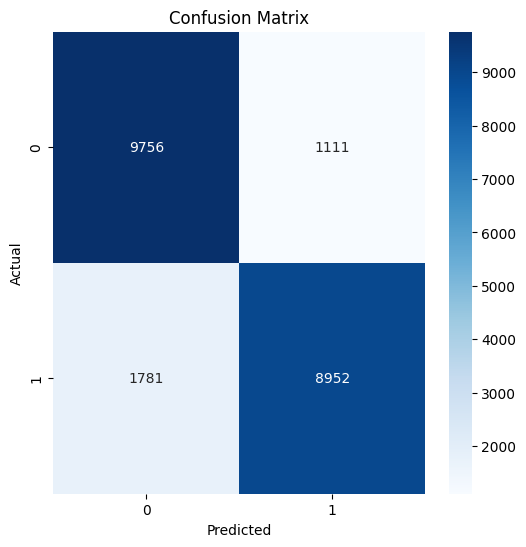

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()